## Look at accelerometer data 
 
Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

# %%

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp
import pickle

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

# %%
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet
# %%
from sklearn.model_selection import train_test_split
#import dask.dataframe as dd

from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Masking
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import tensorflow as tf

In [3]:
# ## Choosing Platform
# Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

# %%
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

# %%
if Computer == "SciClone":
    location = '/sciclone/home/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [4]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home/dchendrickson01/'
    folder = '/scratch/Recordings2/'
    imageFolder = '/scratch/Move3Dprint/'
    
    rootfolder = '/sciclone/home/dchendrickson01/'
    folder = '//sciclone/scr10/dchendrickson01/Recordings2/'
    imageFolder = '//sciclone/scr10/dchendrickson01/Move3Dprint/'

    
    
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

# %% [markdown]
# ## Global Variables

In [5]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0

In [6]:
files = ['230418 recording1.csv','230419 recording1.csv','230420 recording1.csv','230421 recording1.csv']#,
#         '230418 recording2.csv','230419 recording2.csv','230420 recording2.csv','230421 recording2.csv',
#         '230425 recording1.csv','230425 recording2.csv','230426 recording2.csv','230427 recording2.csv',
#         '230428 recording2.csv','230509 recording1.csv','230510 recording1.csv','230511 recording1.csv']

# %%
BeforeTamping = ['221206 recording1.csv','221207 recording1.csv','221208 recording1.csv','221209 recording1.csv',
         '221206 recording2.csv','221207 recording2.csv','221208 recording2.csv','221209 recording2.csv']


# %% [markdown]
# ## Project Specific Functions

In [7]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02):
    SquelchSignal = np.ones(len(DataSet))

    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

def MakeDTs(Seconds, Miliseconds):
    dts = np.zeros(len(Miliseconds), dtype=float)
    dts[0]=1
    for i in range(len(MiliSeconds)-1):
        j = i+1
        if Seconds[j]==Seconds[i]:
            dts[j]=Miliseconds[j]-Miliseconds[i]
        else:
            dts[j]=Miliseconds[j]-Miliseconds[i]+1000
    dts /= 10000
    return dts

In [8]:
def SepreateMovements(SquelchSignal, RawData, FileName, verbose=False):
    Moves= []
    MoveNames = []
    Move = np.zeros((1,3), dtype=float)
    i = 0
    for j in range(len(SquelchSignal)-1):
        if SquelchSignal[j] == 1:
            #try:
            Move = np.concatenate((Move, RawData[:,j].T), axis=0)
            #except:
            #    print(j)
            if SquelchSignal[j+1] == 0:
                #Move = np.matrix(Move)
                Moves.append(Move)
                MoveNames.append(FileName + str(i).zfill(3))
                i+=1
                Move = np.zeros((1,3), dtype=float)
                #Move[0,2]=0
        if verbose:
            if j % 10000 == 0:
                print(j)
    Moves.append(Move)
    MoveNames.append(FileName + str(i).zfill(4))
    return (Moves, MoveNames)
    



    

In [9]:
def splitLong(Moves, maxLength = 4000, minLength = 1000, MoveNames = []):
    if len(MoveNames) <=1:
        MoveNames = ['null'  for x in range(len(Moves))]
    Xmoves = []
    Xnames = []
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] > maxLength: 
            Xmoves.append(Moves[i][:int(len(Moves[i])/2),:])
            Xnames.append(MoveNames[i] + 'a')
            Xmoves.append(Moves[i][int(len(Moves[i])/2):,:])
            Xnames.append(MoveNames[i] + 'b')
        else:
            if np.shape(Moves[i])[0] < minLength:
                pass
            else:
                Xmoves.append(Moves[i])
                Xnames.append(MoveNames[i])
    return Xmoves, Xnames

def findMaxLength(Moves):
    maxLength = 0
    LongMove = 0
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] > maxLength: 
            maxLength =  np.shape(Moves[i])[0]
            LongMove = i
    return maxLength, LongMove

def findMinLength(Moves):
    minLength = 9999999
    SmallMove = 0
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] < minLength: 
            minLength =  np.shape(Moves[i])[0]
            SmallMove = i
    return minLength, SmallMove



# %% [markdown]
# ## Process Files

In [10]:
LoopFiles = 4
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1

print('files', len(files), loops)



files 4 1


In [15]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def DeviationVelocity(file):
    if file[-3:] =='csv':
        ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
        remainder = len(ODataSet[:,3]) % 10
        try:
            SmoothX = cf.Smoothing(ODataSet[:,3].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
            SmoothY = cf.Smoothing(ODataSet[:,4].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
            SmoothZ = cf.Smoothing(ODataSet[:,5].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        except:
            try:
                remainder+=2
                SmoothX = cf.Smoothing(ODataSet[:,3].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
                SmoothY = cf.Smoothing(ODataSet[:,4].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
                SmoothZ = cf.Smoothing(ODataSet[:,5].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
            except:
                remainder+=2
                SmoothX = cf.Smoothing(ODataSet[:,3].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
                SmoothY = cf.Smoothing(ODataSet[:,4].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
                SmoothZ = cf.Smoothing(ODataSet[:,5].T[:-remainder],2,dets_to_remove=3) #denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothX -= np.average(SmoothX)
        SmoothY -= np.average(SmoothY)
        SmoothZ -= np.average(SmoothZ)
        StdDevsX = RollingStdDev(ODataSet[:,3][:-remainder],SmoothX)
        StdDevsX.append(0)
        StdDevsX = np.asarray(StdDevsX).flatten()
        SmoothDevX = cf.Smoothing(StdDevsX,2,dets_to_remove=3)
        AverageStdDev = np.average(StdDevsX)
        StdDevsX -= AverageStdDev
        SquelchSignal = SquelchPattern(np.abs(SmoothX), 500, 0.02)
        last = 0
        running = 0
        for j in range(len(SquelchSignal)):
            if SquelchSignal[j] == 1:
                running+=1
                last = 1
            else:
                if last == 1:
                    if running < 500:
                        SquelchSignal[j-running-1:j+1] = 1
                    running = 0
                last = 0
        #Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
        #Velocity = np.asarray(Velocity)
        MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
        return [SquelchSignal,MoveMatrix,StdDevsX,file[:-4]]
    else:
        pass

In [54]:
original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
ones_list = [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
result = split_list_by_one(original_list, ones_list)

print(result)  # Output: [[1, 2, 3, 8], [4, 5, 6], [8, 9]]

[[1, 2, 3, 8], [4, 5, 6], [8, 9]]


In [53]:
def split_list_by_one(original_list, ones_list):
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, goin to use fo rlong lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

In [13]:
# %%
SquelchSignal = []
RawData=[]
OrderedFileNames=[]
StdDevs=[]


In [16]:
st = ti()

for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    #Results =[]
    #for file in tfiles:
    #    Results.append(DeviationVelocity(file))
    #    print(file, (ti()-st)/60.0)
        
    for i in range(len(Results)):       
        SquelchSignal.append(Results[i][0])
        RawData.append(Results[i][1])
        StdDevs.append(Results[i][2])
        OrderedFileNames.append(Results[i][3])
    print(k, len(Results), (ti()-st)/60.0)
    

0 4 5.459183442592621


In [17]:
print('got data', len(RawData), len(SquelchSignal), np.shape(RawData[0]))

got data 4 4 (3, 18659120)


In [28]:
f = 0
row = np.abs(RawData[f][0,1::100])
np.shape(row)
SS = SquelchSignal[f][1::100]
SD = StdDevs[f][1::100]

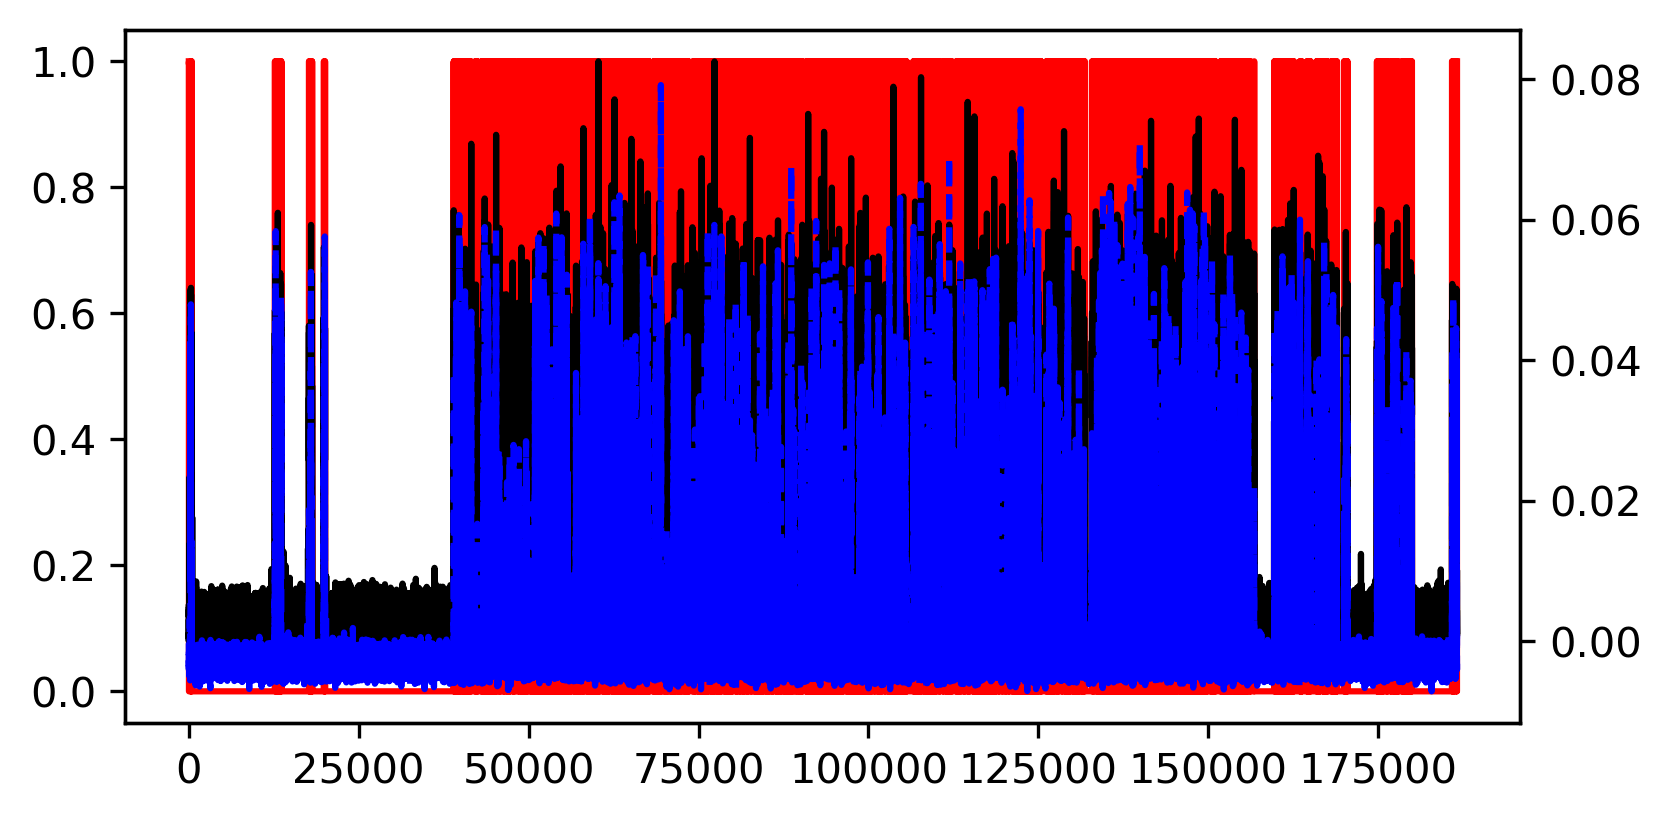

In [29]:
fig,ax1 = plt.subplots(figsize=(6,3),dpi=300)
ax1.plot(SS[:],color='r')
#plt.plot(np.asarray(MoveMatrix[0,:15]))
#ax1.plot(row.T[85000:90000])
ax2=ax1.twinx()
ax2.plot(row.T[:])
ax2.plot(SD[:], color='b')
plt.show()

In [42]:
AllMoves = []
for i in range(16):
    AllMovesX = split_list_by_ones(RawData[i][0,:].T.tolist(),SquelchSignal[i].tolist())
    AllMovesY = split_list_by_ones(RawData[i][1,:].T.tolist(),SquelchSignal[i].tolist())
    AllMovesZ = split_list_by_ones(RawData[i][2,:].T.tolist(),SquelchSignal[i].tolist())
    
    for j in range(len(AllMovesX)):
        AllMoves.append(np.matrix(np.stack((AllMovesX[j],AllMovesY[j],AllMovesZ[j]),axis=1)))

IndexError: list index out of range

In [59]:
def split_list_by_ones(original_list, ones_list):
    result = []
    current_chunk = []

    for value, is_one in zip(original_list, ones_list):
        if is_one == 1.0:  # Adapted condition for 1.0
            current_chunk.append(value)
        elif current_chunk:
            result.append(current_chunk)
            current_chunk = []

    if current_chunk:
        result.append(current_chunk)

    return result

In [71]:
# Example usage
i=1
original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
original_list = RawData[i][0,:].T.tolist()
ones_list = [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
ones_list = SquelchSignal[i].tolist()

AllMovesX = split_list_by_ones(original_list,ones_list)

In [70]:
i=1
len(RawData[i][0,:].T.tolist())

18897948

In [72]:
len(AllMovesX)

1150

In [57]:
# Example usage
i=0
original_list = RawData[i][0,:].tolist()  # Your large original list
ones_list = SquelchSignal[i].tolist()  # Your large ones list
result = split_list_by_ones(original_list, ones_list)

print(result)

TypeError: 'zip' object is not subscriptable

In [ ]:
MoveData = Parallel(n_jobs=31)(delayed(SepreateMovements)(SquelchSignal[i], RawData[i], OrderedFileNames[i])
                                       for i in range(len(RawData)))

In [ ]:
asdfasdf

In [ ]:
#Movements = []
#GroupNames = []
#for move in MoveData:
#    Movements.append(move[0])
#    GroupNames.append(move[1])

#print('Move and Name Sepreated', len(Movements), (ti()-st)/60.0)

In [ ]:
MoveData = []
Moves = []
MoveNames = []

for i in range(len(RawData)):
    temp = SepreateMovements(SquelchSignal[i], RawData[i].T, OrderedFileNames[i])
    print(i, len(temp), len(temp[0]), len(temp[1]))
    for j in range(len(temp[0])):
        Moves.append(temp[0][j])
        MoveNames.append(temp[1][j])
    #MoveData.append(temp)

print('Moves Seperated', len(Moves), (ti()-st)/60.0)
    

In [ ]:
[SquelchSignal,MoveMatrix,SmoothDevX,filename] = DeviationVelocity(files[5])

In [ ]:
np.shape(RawData[0])

In [ ]:
#Moves=[]

#for Groups in Movements:
#    for Move in Groups:
#        Moves.append(np.asarray(Move).astype('float32'))
#Moves = np.asarray(Moves)

#MoveNames = []
#for Groups in GroupNames:
#    for name in Groups:
#        MoveNames.append(name)

In [ ]:
#print('made moves')

del SquelchSignal
del RawData
#del Movements
#del GroupNames
#del MoveData
#del OrderedFileNames

In [ ]:
longMove, MoveNumb = findMaxLength(Moves)

In [ ]:
minLength = 750

In [ ]:
Moves, MoveNames = splitLong(Moves, longMove+1, minLength, MoveNames)

print('Post split length', len(Moves), np.shape(Moves[0]))

In [ ]:
#padding moves.  Not needed, need sequences, not moves

#Moves2 = []
#for move in Moves:
#    if np.shape(move)[0] < longMove:
#        padding = np.zeros((longMove-np.shape(move)[0], 3))
#        tempMove = np.concatenate((move, padding), axis=0)
#        Moves2.append(tempMove)
#    else:
#        Moves2.append(move)
#Moves = Moves2

#del Moves2

## Try LSTM Stuff

 https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [ ]:
TimeSteps = 250
Features = np.shape(Moves[0])[1]

# %%
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# %%
Sequences = []
Outputs = []
for move in Moves:
    Seq, Out = split_sequences(move,TimeSteps)
    Sequences.append(Seq)
    Outputs.append(Out)
    

# %%
MoveSegments = []
for seq in Sequences:
    for mv in seq:
        MoveSegments.append(mv)
NextDataPoint = []
for out in Outputs:
    for pt in out:
        NextDataPoint.append(pt)

# %%
print('data split', len(MoveSegments))
print('Shape next data point', np.shape(NextDataPoint))


file=open('/scratch/PrepAccel/Data-20240307-16files-250pts.p','wb')
pickle.dump([MoveSegments, NextDataPoint],file)
file.close()